In [1]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, train_test_split

from src.visualization.visualize import feature_importance
from src.visualization.scalers import draw_scaler
from src.visualization.correlation import corr_matrix, spearman
from src.seed import set_seed

import warnings

warnings.filterwarnings("ignore")

# Get processed dataset

In [2]:
df = pd.read_csv("../data/processed/df_spb_processed.csv")
df.head(5)

,price,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,level_to_levels,area_to_rooms,parks,parkDistance,subways,subwayDistance
0,6050000,59.805808,30.376141,1,8,10,3,82.6,10.8,1,2018,2,0.800000,27.533333,2500935.0,3000.991571,Купчино,2654.808620
1,3600000,59.875526,30.395457,1,2,5,1,31.1,6.0,1,2018,3,0.400000,31.100000,12320285.0,1301.366381,Международная,1078.709945
2,3200000,59.827465,30.201827,1,7,9,1,31.0,7.0,1,2018,4,0.777778,31.000000,1980423.0,1155.924125,Проспект Ветеранов,3233.926980
3,6500000,59.988334,29.786928,3,3,3,3,89.0,10.0,1,2018,4,1.000000,29.666667,9436216.0,518.049827,Беговая,23096.539408
4,6300000,59.911622,30.284556,3,5,5,2,99.9,14.5,1,2018,4,1.000000,49.950000,10998818.0,126.125497,Балтийская,1101.143050


In [3]:
df.describe()

,price,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,year,month,level_to_levels,area_to_rooms,parks,parkDistance,subwayDistance
count,4.536210e+05,453621.000000,453621.000000,453621.000000,453621.000000,453621.000000,453621.000000,453621.000000,453621.000000,453621.000000,453621.000000,453621.000000,453621.000000,453621.000000,4.536210e+05,453621.000000,453621.000000
mean,7.663511e+06,59.932700,30.319622,1.944348,7.622220,14.432947,1.819296,57.072714,11.667057,5.304541,2019.545449,6.534618,0.543498,32.604040,7.839870e+06,979.267155,2641.322289
std,5.601934e+06,0.084982,0.120607,0.952269,5.703033,7.061781,0.976006,26.600562,5.222620,4.951403,0.855485,3.432817,0.282171,9.830882,4.051040e+06,870.499189,3867.508055
min,1.500000e+06,59.647383,29.509349,0.000000,1.000000,1.000000,0.000000,20.000000,0.000000,1.000000,2018.000000,1.000000,0.032258,2.875000,3.598320e+05,3.544484,3.013156
25%,4.437600e+06,59.863116,30.256757,1.000000,3.000000,9.000000,1.000000,37.700000,8.130000,1.000000,2019.000000,3.000000,0.300000,26.000000,3.322443e+06,462.894159,742.573370
50%,5.940000e+06,59.939084,30.324338,2.000000,6.000000,13.000000,2.000000,50.900000,11.000000,1.000000,2020.000000,7.000000,0.538462,31.550000,7.773686e+06,801.698576,1376.920592
75%,8.711033e+06,60.000338,30.399498,3.000000,11.000000,21.000000,2.000000,68.100000,14.800000,11.000000,2020.000000,10.000000,0.789474,37.500000,1.149001e+07,1218.534562,3006.007484
max,5.000000e+07,60.241984,30.711428,5.000000,35.000000,38.000000,9.000000,200.000000,29.960000,11.000000,2021.000000,12.000000,4.000000,198.000000,1.409280e+07,10490.037606,46469.507505


In [4]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453621 entries, 0 to 453620
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   price            453621 non-null  int64  
 1   geo_lat          453621 non-null  float64
 2   geo_lon          453621 non-null  float64
 3   building_type    453621 non-null  int64  
 4   level            453621 non-null  int64  
 5   levels           453621 non-null  int64  
 6   rooms            453621 non-null  int64  
 7   area             453621 non-null  float64
 8   kitchen_area     453621 non-null  float64
 9   object_type      453621 non-null  int64  
 10  year             453621 non-null  int64  
 11  month            453621 non-null  int64  
 12  level_to_levels  453621 non-null  float64
 13  area_to_rooms    453621 non-null  float64
 14  parks            453621 non-null  float64
 15  parkDistance     453621 non-null  float64
 16  subways          453621 non-null  obje

# EDA

### Correlation matrix

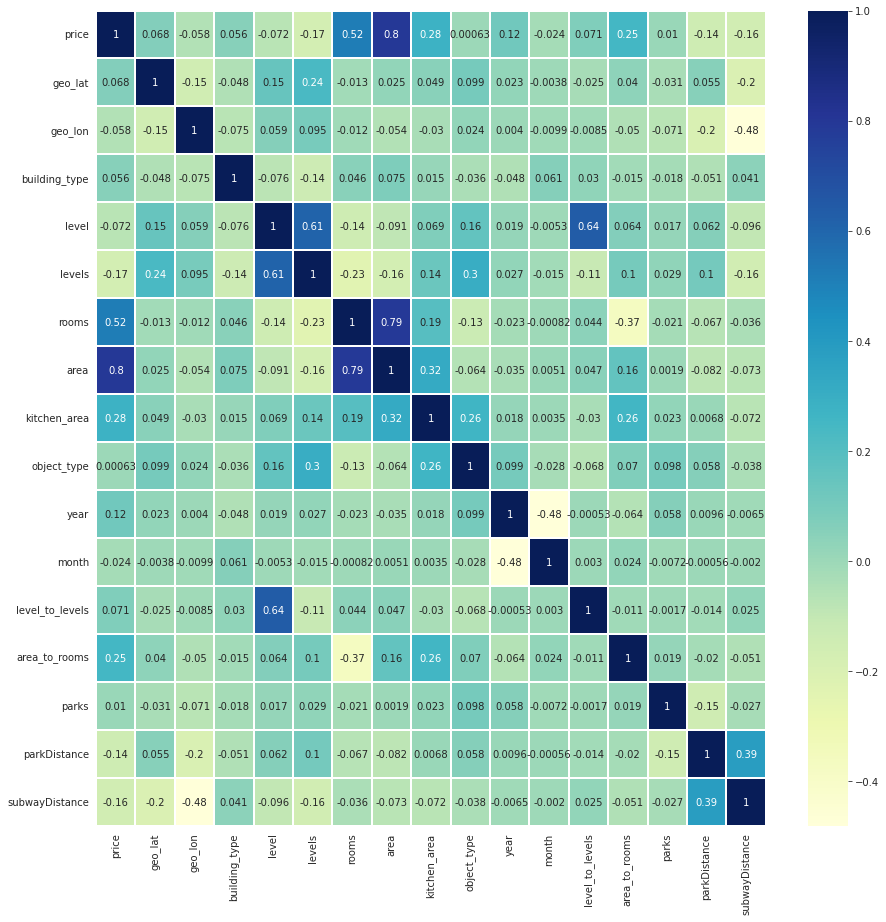

In [5]:
corrmat = corr_matrix(df)

### Sperman correlation

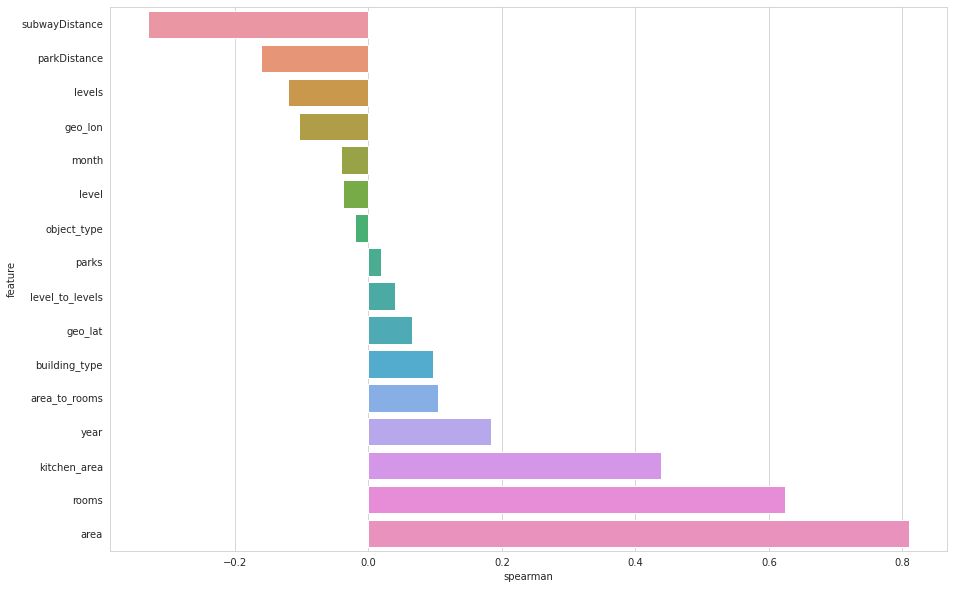

In [6]:
spr = spearman(df, corrmat)

# Feature engineering

# Make Pipline


In [7]:
set_seed()

In [8]:
df = df.select_dtypes(exclude=["object"])
X_full, y_full = df.loc[:, df.columns != "price"], df["price"]

In [9]:
%timeit
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_full, y_full, random_state=0
)
LGBregressor = lgb.LGBMRegressor
pipe = make_pipeline(RobustScaler(), LGBregressor())
param_grid = {
    "lgbmregressor__max_depth": [11],
    "lgbmregressor__num_iterations": [1000],
    "lgbmregressor__learning_rate": [0.1],
    # "lgbmregressor__num_thread": [-1],
}
grid = GridSearchCV(pipe, param_grid, scoring="r2", cv=5, n_jobs=-1)
grid.fit(X_trainval, y_trainval)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('lgbmregressor', LGBMRegressor())]),
             n_jobs=-1,
             param_grid={'lgbmregressor__learning_rate': [0.1],
                         'lgbmregressor__max_depth': [11],
                         'lgbmregressor__num_iterations': [1000]},
             scoring='r2')

In [10]:
# print(grid.best_estimator_)
print(f"Best parameters are {grid.best_params_}")
print(f"Score of training dataset is {grid.score(X_trainval, y_trainval)}")
print(f"Score of testing dataset is {grid.score(X_test, y_test)}")

Best parameters are {'lgbmregressor__learning_rate': 0.1, 'lgbmregressor__max_depth': 11, 'lgbmregressor__num_iterations': 1000}
Score of training dataset is 0.9458173759430758
Score of testing dataset is 0.9256143490130432


### Scaler

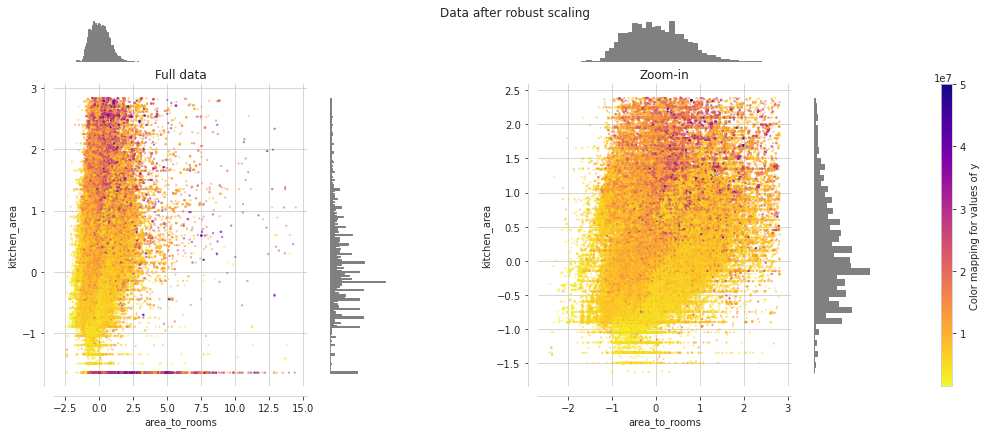

In [11]:
# take dictionary keys, 0-scaler index
scaler = [*grid.best_estimator_.named_steps][0]
# Take only 2 features to make visualization easier
features = ["area_to_rooms", "kitchen_area"]
draw_scaler(X_full, y_full, features, scaler)

### Feature importance

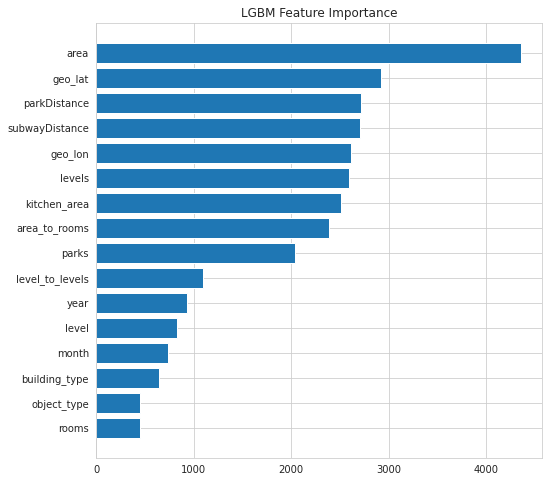

In [12]:
feature_importance(X_full, grid)